In [124]:
import warnings
warnings.filterwarnings('ignore')

In [125]:
import os
import PIL
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Load the data

In [126]:
class HAM10000Dataset(torch.utils.data.Dataset):
    def __init__(self, df, img_dirs, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dirs = img_dirs if isinstance(img_dirs, (list, tuple)) else [img_dirs]
        self.transform = transform
        
        self.path_dict = {}
        for d in self.img_dirs:
            for img_file in os.listdir(d):
                if img_file.endswith('.jpg'):
                    image_id = os.path.splitext(img_file)[0]
                    self.path_dict[image_id] = os.path.join(d, img_file)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['image_id']
        img_path = self.path_dict[image_id]
        image = PIL.Image.open(img_path).convert('RGB')
        label = int(row['label'])
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.df)

In [127]:
# perform contrast stretching
class ContrastStretch(object):
    def __call__(self, img):
        img = torch.as_tensor(img)
        stretched_img = torch.zeros_like(img)

        for c in range(img.shape[0]):
            channel = img[c]
            min_val = channel.min()
            max_val = channel.max()

            if max_val > min_val: 
                stretched_img[c] = (channel - min_val) / (max_val - min_val)
            else:
                stretched_img[c] = channel 

        stretched_img = torch.clamp(stretched_img, 0, 1)
        return stretched_img

In [128]:
img_dir = ['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1',
           '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2']

metadata_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

df = pd.read_csv(metadata_path)

lesion_type_dict = {
    'akiec': 0,
    'bcc': 1,
    'bkl': 2,
    'df': 3,
    'mel': 4,
    'nv': 5,
    'vasc': 6
}

df['label'] = df['dx'].map(lesion_type_dict)

train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomRotation(degrees=(15, 45)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ContrastStretch(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    ContrastStretch(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [129]:

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.125, stratify=train_df['label'], random_state=42)  # 0.125 x 0.8 = 0.1

train_dataset = HAM10000Dataset(train_df, img_dir, train_transform)
val_dataset = HAM10000Dataset(val_df, img_dir, val_test_transform)
test_dataset = HAM10000Dataset(test_df, img_dir, val_test_transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)

# Define CNN model

In [130]:
class SkinCancerCNN(nn.Module):
    def __init__(self, activation='relu'):
        super(SkinCancerCNN, self).__init__()
        self.activation = activation
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            self.get_activation(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            self.get_activation(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            self.get_activation(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            self.get_activation(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(25 * 25 * 64, 128),
            self.get_activation(),
            nn.Dropout(0.5),
            nn.Linear(128, 7),
        )

    def get_activation(self):
        if self.activation == 'relu':
            return nn.ReLU()
        elif self.activation == 'swish':
            return nn.SiLU()
        elif self.activation == 'tanh':
            return nn.Tanh()
        else:
            raise ValueError("Undefined activation function")

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

# Train and evluate the model

In [131]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=5, patience=10):
    train_acc_history, val_acc_history = [], []
    train_loss_history, val_loss_history = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        train_loss = running_loss / len(train_loader)
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        val_loss = val_loss / len(val_loader)
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

    return train_acc_history, val_acc_history, train_loss_history, val_loss_history

def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_loader)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    cm = confusion_matrix(all_labels, all_preds)
    precision, recall, _, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)

    return test_acc, test_loss, cm, precision, recall

# Run the Experment

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

activations = ['relu', 'swish', 'tanh']
optimizers = [
    ('Adam', optim.Adam),
    ('RMSprop', optim.RMSprop)
]
results = {}

for activation in activations:
    for opt_name, opt_class in optimizers:
        print(f'\nTraining with {activation} activation and {opt_name} optimizer')

        # Init
        model = SkinCancerCNN(activation=activation).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = opt_class(model.parameters(), lr=0.001)
        # Train
        train_acc, val_acc, train_loss, val_loss = train_model(
            model, train_loader, val_loader, optimizer, criterion
        )
        # Evaluate
        test_acc, test_loss, cm, precision, recall = evaluate_model(model, test_loader, criterion)

        # Store results
        results[(activation, opt_name)] = {
            'train_acc': train_acc[-1],
            'val_acc': val_acc[-1],
            'test_acc': test_acc,
            'train_loss': train_loss[-1],
            'val_loss': val_loss[-1],
            'test_loss': test_loss,
            'cm': cm,
            'precision': precision,
            'recall': recall
        }


Training with relu activation and Adam optimizer
Epoch [1/5], Train Loss: 2.1919, Train Acc: 61.91%, Val Loss: 1.1437, Val Acc: 67.07%
Epoch [2/5], Train Loss: 1.1474, Train Acc: 66.85%, Val Loss: 1.1046, Val Acc: 67.07%
Epoch [3/5], Train Loss: 1.1050, Train Acc: 66.93%, Val Loss: 1.1597, Val Acc: 65.77%
Epoch [4/5], Train Loss: 1.0650, Train Acc: 66.73%, Val Loss: 1.0604, Val Acc: 66.97%
Epoch [5/5], Train Loss: 1.0373, Train Acc: 67.02%, Val Loss: 1.0815, Val Acc: 66.97%
Test Loss: 1.0920, Test Accuracy: 67.00%

Training with relu activation and RMSprop optimizer
Epoch [1/5], Train Loss: 7.0681, Train Acc: 60.86%, Val Loss: 1.7393, Val Acc: 66.97%
Epoch [2/5], Train Loss: 1.3781, Train Acc: 65.26%, Val Loss: 1.6424, Val Acc: 66.97%
Epoch [3/5], Train Loss: 1.2039, Train Acc: 66.72%, Val Loss: 1.2637, Val Acc: 66.97%
Epoch [4/5], Train Loss: 1.1611, Train Acc: 66.85%, Val Loss: 1.1886, Val Acc: 66.97%
Epoch [5/5], Train Loss: 1.1369, Train Acc: 66.89%, Val Loss: 1.3716, Val Acc: 67.

---

In [142]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [143]:
def predict_fn(images):
    model.eval()
    processed_images = []
    for img in images:
        img_tensor = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)
        img_tensor = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(img_tensor)
        processed_images.append(img_tensor.unsqueeze(0))
    images_tensor = torch.cat(processed_images).to(device)
    with torch.no_grad():
        outputs = model(images_tensor)
    return torch.softmax(outputs, dim=1).cpu().numpy()

In [144]:
for images, labels in test_loader:
    img = images[1]
    label = labels[1].item()
    break

img_np = img.cpu().numpy().transpose(1, 2, 0)
img_np = img_np * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
img_np = np.clip(img_np, 0, 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

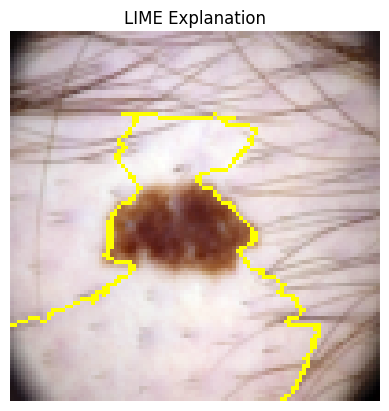

In [145]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    img_np,
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(img_np, mask))
plt.title('LIME Explanation')
plt.axis('off')
plt.show()